# LDA Topic Modeling

In [1]:
# Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# NLTK for Text Preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
import re

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Progress Bar
from tqdm import tqdm

# Gensim for LDA Topic Modeling
import gensim
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel

# PyLDAvis for Topic Visualization
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


The URLs below point to XLSX files containing tweets from 2022 from the following Twitter accounts:

- [@TheBeaverton](https://twitter.com/TheBeaverton)
- [@BillNye](https://twitter.com/BillNye) (Bill Nye)
- [@GeorgeTakei](https://twitter.com/GeorgeTakei) (George Takei)
- [@MeCookieMonster](https://twitter.com/MeCookieMonster) (Cookie Monster)
- [@neiltyson](https://twitter.com/neiltyson) (Neil deGrasse Tyson)
- [@StephenKing](https://twitter.com/StephenKing) (Stephen King)
- [@22_Minutes](https://twitter.com/22_Minutes) (This Hour Has 22 Minutes)

## Data Loading and Exploration

In [2]:
beaverton_url = 'https://drive.google.com/uc?export=download&id=173t6vMYcbSED81IOmg0MbhHsrSFSiF21'
billnye_url = 'https://drive.google.com/uc?export=download&id=1w1Xm-TQfcPfGICM_8_LQiWSqzf8WUk8N'
georgetakei_url = 'https://drive.google.com/uc?export=download&id=1_Ck9S2aW9cBQQrqoTiNLRmvRu4WvPn8y'
cookiemonster_url = 'https://drive.google.com/uc?export=download&id=10Av-HVklZA4Su3TcvSpxU6nS8At9mJ05'
neiltyson_url = 'https://drive.google.com/uc?export=download&id=1GSKxxldXe--HE4gSYAEn2ip2vS4bXKMM'
stephenking_url = 'https://drive.google.com/uc?export=download&id=1Oq2pUCv0d7x4tDKX1E-3hgdSAuXcZtVU'
twentytwo_minutes_url = 'https://drive.google.com/uc?export=download&id=1B2zwAJYdw_9skXAFbn7QIs6uyIikje5W'

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
beaverton = pd.read_excel(beaverton_url, engine='openpyxl')
beaverton.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet-id,tweet-text,tweet-author,tweet-timestamp-date
0,1,Heartwarming: This man reconnected with his mo...,The Beaverton,2022-03-05
1,2,OP-ED: Big Pharma put all of the chips in the ...,The Beaverton,2022-03-04
2,3,Make every day a 'talking to Americans about t...,The Beaverton,2022-03-04
3,4,Single drop of sweat falls down local dad’s fa...,The Beaverton,2022-03-04
4,5,100% of Canadians pretty sure they’ve had COVI...,The Beaverton,2022-03-03


In [4]:
billnye = pd.read_excel(billnye_url, engine='openpyxl')
billnye.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet-id,tweet-text,tweet-author,tweet-timestamp-date
0,1,"Happy Twosday, people(s). That’s right, it’s 2...",Bill Nye,2022-02-22
1,2,Dr. King would be 93 years old this week. The ...,Bill Nye,2022-01-17
2,3,Happy Isaac Newton’s Birthday James Webb Space...,Bill Nye,2021-12-25
3,4,"Please, consider the following… my new VR Spac...",Bill Nye,2021-12-14
4,5,Winter tornadoes… warm winter in the south & c...,Bill Nye,2021-12-12


In [5]:
georgetakei = pd.read_excel(georgetakei_url, engine='openpyxl')
georgetakei.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet-id,tweet-text,tweet-author,tweet-timestamp-date
0,1,He is still sorely missed. 💕 What is your favo...,georgetakei,2022-03-12
1,2,It’s terrifying but true. The GOP has become t...,georgetakei,2022-03-12
2,3,This is not normal.,georgetakei,2022-03-12
3,4,"Very well put, indeed.",georgetakei,2022-03-12
4,5,"With the former guy, mockery is the best polic...",georgetakei,2022-03-12


In [6]:
cookiemonster = pd.read_excel(cookiemonster_url, engine='openpyxl')
cookiemonster.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet-id,tweet-text,tweet-author,tweet-timestamp-date
0,1,"Today, me so thankful for chefs like me friend...",MeCookieMonster,2022-03-08
1,2,You can’t spell cookie without “oo.” Speaking ...,MeCookieMonster,2022-02-25
2,3,Me so grateful @SesameErnie\n. Me think sharin...,MeCookieMonster,2022-02-17
3,4,What do me love? Friends. Family. Cookies. Ple...,MeCookieMonster,2022-02-14
4,5,"Dipping cookies in milk? Me get it, but who ha...",MeCookieMonster,2022-01-28


In [7]:
neiltyson = pd.read_excel(billnye_url, engine='openpyxl')
neiltyson.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet-id,tweet-text,tweet-author,tweet-timestamp-date
0,1,"Happy Twosday, people(s). That’s right, it’s 2...",Bill Nye,2022-02-22
1,2,Dr. King would be 93 years old this week. The ...,Bill Nye,2022-01-17
2,3,Happy Isaac Newton’s Birthday James Webb Space...,Bill Nye,2021-12-25
3,4,"Please, consider the following… my new VR Spac...",Bill Nye,2021-12-14
4,5,Winter tornadoes… warm winter in the south & c...,Bill Nye,2021-12-12


In [8]:
stephenking = pd.read_excel(stephenking_url, engine='openpyxl')
stephenking.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet-id,tweet-text,tweet-author,tweet-timestamp-date
0,1,What kind of dinosaur writes romance novels? A...,StephenKing,2022-03-05
1,2,"Molly, aka the Thing of Evil, fools my friend ...",StephenKing,2022-02-25
2,3,Two questions (and a codicil) about MANIFEST: ...,StephenKing,2022-02-25
3,4,What most of us learned as kids on the playgro...,StephenKing,2022-02-23
4,5,"I need baseball! Come on you guys, stop being ...",StephenKing,2022-02-16


In [9]:
twentytwo_minutes = pd.read_excel(twentytwo_minutes_url, engine='openpyxl')
twentytwo_minutes.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet-id,tweet-text,tweet-author,tweet-timestamp-date
0,1,"And in lighter news this week: Nope, sorry. We...",22Minutes,2022-03-03 00:00:00
1,2,Dee Snider of Twisted Sister says he approves ...,22Minutes,2022-03-03 00:00:00
2,3,Tim Hortons will be releasing their own line o...,22Minutes,2022-03-03 00:00:00
3,4,A new survey shows that 1 in 8 people suffer f...,22Minutes,2022-03-02 00:00:00
4,5,The Bank of Canada has raised its interest rat...,22Minutes,2022-03-02 00:00:00


In [10]:
beaverton['account'] = 'The Beaverton'
billnye['account'] = 'Bill Nye'
georgetakei['account'] = 'George Takei'
cookiemonster['account'] = 'Cookie Monster'
neiltyson['account'] = 'Neil deGrasse Tyson'
stephenking['account'] = 'Stephen King'
twentytwo_minutes['account'] = 'This Hour Has 22 Minutes'

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
data = pd.concat([beaverton, billnye, georgetakei, cookiemonster, neiltyson, stephenking, twentytwo_minutes], ignore_index=True)
data.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet-id,tweet-text,tweet-author,tweet-timestamp-date,account
0,1,Heartwarming: This man reconnected with his mo...,The Beaverton,2022-03-05 00:00:00,The Beaverton
1,2,OP-ED: Big Pharma put all of the chips in the ...,The Beaverton,2022-03-04 00:00:00,The Beaverton
2,3,Make every day a 'talking to Americans about t...,The Beaverton,2022-03-04 00:00:00,The Beaverton
3,4,Single drop of sweat falls down local dad’s fa...,The Beaverton,2022-03-04 00:00:00,The Beaverton
4,5,100% of Canadians pretty sure they’ve had COVI...,The Beaverton,2022-03-03 00:00:00,The Beaverton


In [12]:
data.tail()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet-id,tweet-text,tweet-author,tweet-timestamp-date,account
1071,196,A student at U of T is launching a city-wide s...,22Minutes,2021-09-17 00:00:00,This Hour Has 22 Minutes
1072,197,New poll shows nearly half of Canadians don’t ...,22Minutes,2021-09-17 00:00:00,This Hour Has 22 Minutes
1073,198,Apple has introduced the iPhone 13! Huge! Mass...,22Minutes,2021-09-16 00:00:00,This Hour Has 22 Minutes
1074,199,The Price Is Right is celebrating its 50th yea...,22Minutes,2021-09-15 00:00:00,This Hour Has 22 Minutes
1075,200,Some restaurants are reporting a shortage of c...,22Minutes,2021-09-15 00:00:00,This Hour Has 22 Minutes


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1076 entries, 0 to 1075
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   tweet-id              1076 non-null   int64 
 1   tweet-text            1076 non-null   object
 2   tweet-author          1076 non-null   object
 3   tweet-timestamp-date  1076 non-null   object
 4   account               1076 non-null   object
dtypes: int64(1), object(4)
memory usage: 42.2+ KB


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Text Preprocessing

In [14]:
# to initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
def preprocess_text(text):
    """
    Preprocesses text by:
    - Expanding contractions (e.g., "don't" → "do not")
    - Removing punctuation
    - Tokenizing
    - Lowercasing
    - Removing stopwords
    - Lemmatizing
    - Removing standalone short words (<=2 characters)
    - Removing numbers

    Returns:
    -------
    List of cleaned tokens.
    """

    # Expand Contractions (Ensures "don't" → "do not")
    text = re.sub(r"n't", " not", text)  # "can't" → "can not"
    text = re.sub(r"'m", " am", text)  # "I'm" → "I am"
    text = re.sub(r"'re", " are", text)  # "You're" → "You are"
    text = re.sub(r"'ll", " will", text)  # "I'll" → "I will"
    text = re.sub(r"'ve", " have", text)  # "I've" → "I have"
    text = re.sub(r"'s", "", text)  # Removes possessives (e.g., "child's" → "child")

    # Remove All Punctuation
    text = re.sub(r"[^\w\s]", "", text)  # Removes all punctuation after expanding contractions

    # Tokenization
    tokens = word_tokenize(text)

    # Lowercasing
    tokens = [token.lower() for token in tokens]

    # Stopword Removal
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove Short Words (<=2 characters, except "I" and "am")
    tokens = [token for token in tokens if len(token) > 2 or token in {"i", "am"}]

    # Remove Numbers
    tokens = [token for token in tokens if not token.isdigit()]

    return tokens

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
tqdm.pandas() # tqdm.pandas() integrates the tqdm progress bar with pandas, allowing you to track progress when using .apply() on DataFrames or Series.
data['processed_tweet_text'] = data['tweet-text'].progress_apply(preprocess_text)
data[['tweet-text', 'processed_tweet_text']].head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 1076/1076 [00:06<00:00, 155.81it/s]


,tweet-text,processed_tweet_text
0,Heartwarming: This man reconnected with his mo...,"[heartwarming, man, reconnected, mom, could, a..."
1,OP-ED: Big Pharma put all of the chips in the ...,"[oped, big, pharma, put, chip, vaccine, get, ps5]"
2,Make every day a 'talking to Americans about t...,"[make, every, day, talking, american, healthca..."
3,Single drop of sweat falls down local dad’s fa...,"[single, drop, sweat, fall, local, dad, face, ..."
4,100% of Canadians pretty sure they’ve had COVI...,"[canadian, pretty, sure, theyve, covid, already]"


In [17]:
for text in data['processed_tweet_text'].head(25):
    print(text)

['heartwarming', 'man', 'reconnected', 'mom', 'could', 'ask', 'tax']
['oped', 'big', 'pharma', 'put', 'chip', 'vaccine', 'get', 'ps5']
['make', 'every', 'day', 'talking', 'american', 'healthcare', 'system', 'level', 'smug', 'day', 'shirt']
['single', 'drop', 'sweat', 'fall', 'local', 'dad', 'face', 'tell', 'daycare', 'worker', 'child', 'doesnt', 'runny', 'nose']
['canadian', 'pretty', 'sure', 'theyve', 'covid', 'already']
['local', 'fiancé', 'insists', 'buying', 'wedding', 'ring', 'bulk', 'totally', 'normal']
['congressional', 'bouncer', 'apologize', 'admitting', 'rowdy', 'bachelorette', 'party', 'state', 'union', 'stateoftheunion']
['immersive', 'art', 'experience', 'really', 'two', 'sens']
['political', 'cartoonist', 'mistaken', 'impression', 'political', 'cartoonist', 'never', 'important']
['climate', 'change', 'considering', 'makeover', 'stand', 'amongst', 'shiny', 'new', 'calamity']
['scientist', 'invents', 'time', 'travel', 'mock', 'people', 'thought', 'thing', 'bad']
['quiz', 'r

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##  Corpus Preparation, LDA Model Training, and Topic Evaluation

This section prepares the processed text for LDA topic modelling by creating a structured corpus and training the model using Gensim.

In [18]:
# Creates a dictionary where each unique word gets a unique integer ID.
# The dictionary stores how many times each word appears across all documents.
id2word = corpora.Dictionary(data['processed_tweet_text'])

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
# Converts each document (text, which is a list of words) into a sparse vector.
corpus = [id2word.doc2bow(text) for text in data['processed_tweet_text']]
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
[[(id2word[i], freq) for i, freq in doc] for doc in corpus[:1]]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[('ask', 1),
  ('could', 1),
  ('heartwarming', 1),
  ('man', 1),
  ('mom', 1),
  ('reconnected', 1),
  ('tax', 1)]]

### Why These Parameters?

- `num_topics=5`: Each account likely discusses a few main themes. Using five topics per account helps keep topics clear and meaningful without making them too broad or too specific. **Experimenting with coherence scores** can determine the optimal number.
- `passes=50`: Runs the model enough times to find good topics without wasting time on extra passes that don't add much improvement.
- `update_every=1`: Updates the model after each batch of documents, making training faster and more memory-efficient, especially for large datasets.
- `chunksize=200`: Processes 200 documents at a time, which makes training faster and helps the model find more stable topics.
- `alpha='auto'`: Automatically adjusts how many topics each document contains, so the model can decide if a document should focus on just one topic or multiple topics.
- `per_word_topics=False`: Speeds up processing by skipping extra details about individual words, which are not usually needed for topic analysis.

In [21]:
# Train a single LDA model on all accounts together
lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=15,  # Adjust based on coherence score testing
    passes=50,
    update_every=1,
    chunksize=200,
    alpha='auto',
    per_word_topics=False
)

# The coherence score measures how well the words in a topic are related, helping us evaluate the quality of the LDA model.
# A higher coherence score means better topics, making the model more useful!
# The coherence score in LDA topic modeling typically ranges between 0 and 1, but it does not have strict theoretical bounds.
# A higher coherence score (~0.5 to 0.7) means the topics are well-formed and useful!
coherence_model = CoherenceModel(
    model=lda_model,
    texts=data['processed_tweet_text'],
    dictionary=id2word,
    coherence='c_v'
)
coherence_score = coherence_model.get_coherence()

# Print the overall coherence score and topics
print(f"LDA Model Trained on All Accounts (Coherence Score: {coherence_score:.4f})")
print("=" * 100)

for topic_id, topic in lda_model.show_topics(formatted=True, num_words=10):
    print(f"Topic {topic_id + 1}: {topic}")

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LDA Model Trained on All Accounts (Coherence Score: 0.5250)
Topic 11: 0.067*"two" + 0.035*"people" + 0.035*"international" + 0.028*"company" + 0.022*"station" + 0.022*"astronaut" + 0.019*"space" + 0.018*"three" + 0.017*"flight" + 0.017*"keep"
Topic 14: 0.031*"stop" + 0.026*"movie" + 0.025*"stay" + 0.024*"name" + 0.024*"moon" + 0.017*"fear" + 0.014*"system" + 0.013*"dark" + 0.013*"amazing" + 0.013*"seems"
Topic 1: 0.074*"canadian" + 0.034*"word" + 0.029*"line" + 0.028*"night" + 0.025*"cool" + 0.018*"anyone" + 0.018*"food" + 0.016*"covid" + 0.016*"true" + 0.016*"owner"
Topic 8: 0.078*"like" + 0.035*"half" + 0.024*"well" + 0.023*"found" + 0.020*"oldest" + 0.019*"average" + 0.019*"america" + 0.017*"wonder" + 0.017*"dog" + 0.014*"put"
Topic 12: 0.033*"cdnpoli" + 0.028*"news" + 0.027*"space" + 0.024*"elxn44" + 0.023*"birthday" + 0.021*"city" + 0.018*"nasa" + 0.014*"street" + 0.014*"canadian" + 0.014*"working"
Topic 15: 0.039*"like" + 0.034*"lot" + 0.029*"sure" + 0.021*"election" + 0.018*"sou

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


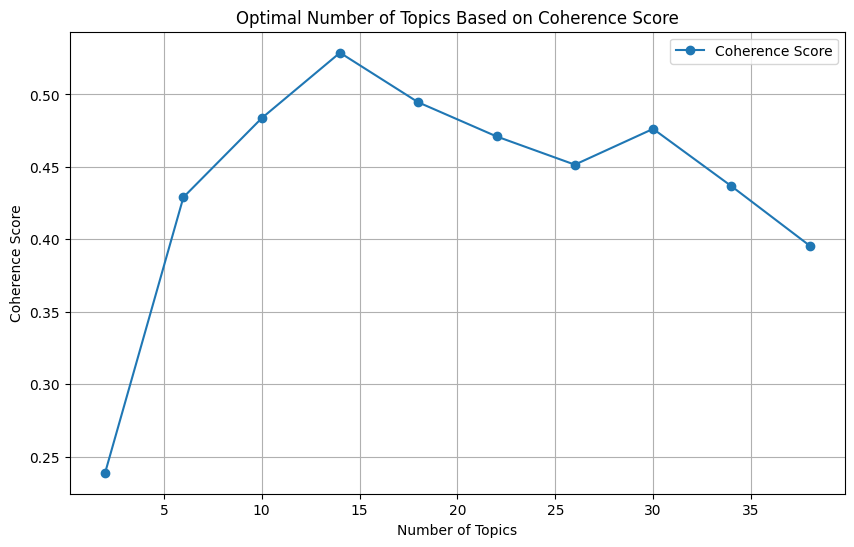

In [22]:
# Function to compute coherence values for different topic numbers
def compute_coherence_values(dictionary, corpus, texts, start=2, limit=40, step=4):
    coherence_values = []
    model_list = []
    num_topics_list = range(start, limit + 1, step)

    for num_topics in num_topics_list:
        model = gensim.models.LdaModel(
            corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=50,
            update_every=1, chunksize=200, alpha='auto', per_word_topics=False)
        model_list.append(model)

        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())

    return model_list, coherence_values, num_topics_list

# Run the function to compute coherence scores for various topic numbers
model_list, coherence_values, num_topics_list = compute_coherence_values(
    dictionary=id2word,
    corpus=corpus,
    texts=data['processed_tweet_text'],
    start=2,
    limit=40,
    step=4
)

# Plot coherence scores
plt.figure(figsize=(10, 6))
plt.plot(num_topics_list, coherence_values, marker='o', linestyle='-')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Optimal Number of Topics Based on Coherence Score")
plt.legend(["Coherence Score"], loc='best')
plt.grid(True);

It looks like the **coherence score increases with the increase in the number of topics**. We will use the model with the highest coherence score:

In [23]:
# Find the index of the best coherence score
best_result_index = coherence_values.index(max(coherence_values))

# Select the optimal model based on the highest coherence score
optimal_model = model_list[best_result_index]

# Get the best number of topics
best_num_topics = num_topics_list[best_result_index]

# Print the best number of topics and its coherence score
print(f"The optimal number of topics is {best_num_topics}, achieving the highest coherence score of {coherence_values[best_result_index]:.4f}.")

# Display the top topics from the optimal model
print("=" * 100)
for topic_id, topic in optimal_model.show_topics(formatted=True, num_words=10):
    print(f"Topic {topic_id + 1}: {topic}")

The optimal number of topics is 14, achieving the highest coherence score of 0.5288.
Topic 4: 0.027*"monster" + 0.021*"there" + 0.020*"tonight" + 0.016*"winter" + 0.015*"called" + 0.014*"covered" + 0.014*"theyve" + 0.014*"side" + 0.014*"ground" + 0.013*"friday"
Topic 6: 0.035*"due" + 0.020*"world" + 0.016*"iphone" + 0.016*"mean" + 0.016*"everywhere" + 0.016*"thank" + 0.015*"party" + 0.015*"ceo" + 0.014*"live" + 0.014*"person"
Topic 11: 0.019*"minute" + 0.019*"help" + 0.018*"average" + 0.018*"away" + 0.017*"facebook" + 0.016*"apple" + 0.014*"thinking" + 0.013*"used" + 0.013*"planning" + 0.013*"mouth"
Topic 5: 0.026*"stop" + 0.025*"mar" + 0.021*"hope" + 0.018*"calling" + 0.018*"may" + 0.017*"least" + 0.017*"else" + 0.015*"phone" + 0.015*"around" + 0.015*"part"
Topic 12: 0.029*"space" + 0.027*"first" + 0.019*"exploreplanets" + 0.017*"best" + 0.017*"human" + 0.015*"fall" + 0.014*"think" + 0.014*"child" + 0.014*"asteroid" + 0.014*"exploration"
Topic 3: 0.027*"world" + 0.022*"taco" + 0.022*"

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's see how the words are clustered using pyLDAVis.

In [24]:
# Creating Topic Distance Visualization
p = gensimvis.prepare(optimal_model, corpus, id2word)
p

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.370671 -0.136926       1        1  23.182852
9     -0.147841  0.275674       2        1  11.774587
8      0.034560  0.026606       3        1   8.539887
2      0.014054  0.124988       4        1   7.595146
0      0.026408 -0.055111       5        1   7.535797
1      0.029658 -0.050515       6        1   7.355804
6      0.037384 -0.029394       7        1   6.845292
11     0.050053 -0.042799       8        1   5.452231
7      0.065306 -0.054046       9        1   4.616261
4      0.053495  0.004810      10        1   4.408653
13     0.048367 -0.043676      11        1   4.223545
10     0.047220  0.001483      12        1   3.419798
5      0.054583 -0.016159      13        1   3.165968
3      0.057423 -0.004935      14        1   1.884179, topic_info=          Term        Freq       Total Category  logprob  loglift
148        say   84.000000   84.000000  Default  30.0000  30.0000
16         day  134.000000  134.000000  Default  29.0000  29.0000
2035    cookie   60.000000   60.000000  Default  28.0000  28.0000
802      today  110.000000  110.000000  Default  27.0000  27.0000
2039     cooky   56.000000   56.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
2173  follower    0.851116    1.632777  Topic14  -5.6145   3.3202
1195       bob    0.812491    1.594150  Topic14  -5.6609   3.2977
298     winter    3.641705    8.426279  Topic14  -4.1608   3.1328
1058  solstice    1.636568    3.596459  Topic14  -4.9607   3.1843
1006     ahead    1.631505    5.060183  Topic14  -4.9638   2.8398

[556 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3715      6  0.909340     1000lbs
829      12  0.883350        able
805      12  0.837628  accomplish
2743     12  0.895081   according
507       6  0.976909    actually
...     ...       ...         ...
554       3  0.945614       wrong
290       1  0.966123        year
290      12  0.021233        year
1124      5  0.954443       young
2742      7  0.896466         zoo

[638 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 10, 9, 3, 1, 2, 7, 12, 8, 5, 14, 11, 6, 4])